In [1]:
import os

#os.chdir('/content/drive/My Drive/Colab Notebooks/neuzz-master/')
os.chdir('/content/drive/My Drive/Colab Notebooks/neuzz-master/programs/mupdf')

In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import os
import sys
import glob
import time
import keras
import random
import subprocess
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

MAX_FILE_SIZE = 0
MAX_BITMAP_SIZE = 0
reduced_Features = 0.95

batch_size = 64
epochs = 200
validation_split = 0.25 # (6:2:2)

# Choose a seed for random initilzation
# seed = int(time.time())
#Rseed = 12
#np.random.seed(Rseed)
#random.seed(Rseed)
#tf.random.set_seed(Rseed)

X_train = None
X_test = None
y_train = None
y_test = None

# process training data from afl raw data
def process_data():
    global MAX_BITMAP_SIZE
    global MAX_FILE_SIZE
    global X_train, X_test, y_train, y_test

    X_train = np.load('X_train.npy')
    y_train = np.load('y_train.npy')
    X_test = np.load('X_test.npy')
    y_test = np.load('y_test.npy')
    MAX_FILE_SIZE = X_train.shape[1]
    MAX_BITMAP_SIZE = y_train.shape[1]

    """
    # shuffle training samples
    seed_list = glob.glob('./crawl_seeds/*')
    seed_list.sort()

    # get MAX_FILE_SIZE
    cwd = os.getcwd()
    max_file_name = subprocess.check_output(['ls', '-S', cwd + '/crawl_seeds/']).decode('utf8').split('\n')[0].rstrip('\n')
    MAX_FILE_SIZE = os.path.getsize(cwd + '/crawl_seeds/' + max_file_name)

    X = np.zeros((len(seed_list), MAX_FILE_SIZE), dtype=np.uint8)
    bitmap = np.zeros((len(seed_list),65536), dtype=np.uint8)

    for idx, f in enumerate(seed_list):
        print (idx)
        fd_seed = open(f, 'rb')
        seed_file = fd_seed.read()
        X[idx, 0:len(seed_file)] = np.frombuffer(seed_file, dtype=np.uint8)
        fd_seed.close()

        tmp_list = []
        bitmap_fn = "./crawl_bitmaps/" + f[13:] + ".bitmap"
        fd_bitmap = open(bitmap_fn, 'r')
        out = fd_bitmap.read().encode()
        fd_bitmap.close()
        for line in out.splitlines():
            edge = line.split(b':')[0]
            cnt = line.split(b':')[1]
            bitmap[idx, int(edge)] = int(cnt)

    # label dimension reduction
    y = np.unique(bitmap, axis=1)
    MAX_BITMAP_SIZE = y.shape[1]

    X = X / np.max(X)
    y = y / np.max(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    np.save('X_train.npy', X_train)
    np.save('y_train.npy', y_train)
    np.save('X_test.npy', X_test)
    np.save('y_test.npy', y_test)
    """

    print("X_train dimension" + str(X_train.shape))
    print("X_test dimension" + str(X_test.shape))
    print("y_train dimension" + str(y_train.shape))
    print("y_test dimension" + str(y_test.shape))

# process training data from afl raw data with PCA
def process_data_with_PCA():
    global MAX_BITMAP_SIZE
    global MAX_FILE_SIZE
    global X_train, X_test, y_train, y_test

    X_train = np.load('pca_X_train.npy')
    y_train = np.load('y_train.npy')
    X_test = np.load('pca_X_test.npy')
    y_test = np.load('y_test.npy')
    MAX_FILE_SIZE = X_train.shape[1]
    MAX_BITMAP_SIZE = y_train.shape[1]

    """
    process_data()

    pca = PCA(reduced_Features)
    pca.fit(X_train)
    pca_X_train = pca.transform(X_train)
    pca_X_test = pca.transform(X_test)

    np.save('pca_X_train.npy', pca_X_train)
    np.save('pca_X_test.npy', pca_X_test)

    print("X_train dimension" + str(X_train.shape))
    print("X_test dimension" + str(X_test.shape))
    print("pca_X_train dimension" + str(pca_X_train.shape))
    print("pca_X_test dimension" + str(pca_X_test.shape))
    print("y_train dimension" + str(y_train.shape))
    print("y_test dimension" + str(y_test.shape))

    MAX_FILE_SIZE = pca_X_train.shape[1]
    X_train = pca_X_train
    X_test = pca_X_test
    """

def process_data_with_LSTM_AE():
    assert(False)
    global MAX_BITMAP_SIZE
    global MAX_FILE_SIZE
    global X_train, X_test, y_train, y_test
    reduced_Features = 500


    #process_data()
    X_train = np.load('X_train.npy')

    print (X_train)

    # reshape input into [samples, timesteps, features]
    samples = X_train.shape[0]
    timesteps = X_train.shape[1]
    X_train = X_train.reshape((samples, timesteps, 1))
    #X_test_res = X_test.reshape((X_test.shape[0], timesteps, 1))

    # define model
    model = keras.Sequential()
    model.add(layers.LSTM(reduced_Features, activation='relu', input_shape=(timesteps, 1)))
    model.add(layers.RepeatVector(timesteps))
    model.add(layers.LSTM(reduced_Features, activation='relu', return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(1)))
    model.compile(optimizer='adam', loss='mse')
    model.summary()

    # fit model
    model.fit(X_train, X_train, epochs=300, verbose=1)

    encoder = Model(model.input, model.layers[0].output)
    encoder.summary()

    AE_X_train = encoder(X_train)
    #AE_X_test = encoder(X_test_res)

    np.save('AE_X_train.npy', AE_X_train)
    #np.save('AE_X_test.npy', AE_X_test)

    
def process_data_with_AE():
    global MAX_BITMAP_SIZE
    global MAX_FILE_SIZE
    global X_train, X_test, y_train, y_test

    
    X_train = np.load('AE_X_train.npy')
    y_train = np.load('y_train.npy')
    X_test = np.load('AE_X_test.npy')
    y_test = np.load('y_test.npy')
    MAX_FILE_SIZE = X_train.shape[1]
    MAX_BITMAP_SIZE = y_train.shape[1]
    """
    reduced_Features = 2500


    process_data()
    origin_Features = X_train.shape[1]

    # define model
    model = keras.Sequential()
    model.add(layers.Dense(reduced_Features, activation='relu'))
    model.add(layers.Dense(origin_Features, activation='sigmoid'))
    model.compile(optimizer='adam', loss='mse')

    # fit model
    model.fit(X_train, X_train, epochs=200, verbose=1)

    encoder = keras.Model(model.input, model.layers[0].output)
    encoder.summary()

    AE_X_train = encoder(X_train)
    AE_X_test = encoder(X_test)

    np.save('AE_X_train.npy', AE_X_train)
    np.save('AE_X_test.npy', AE_X_test)
    """

def train(model):
    global x_train
    global y_train
    global batch_size
    global epochs
    global validation_split

    history = model.fit(x = X_train, y = y_train, batch_size = batch_size,
     epochs = epochs, verbose=2, validation_split = validation_split)
    
    return history
    

def process(settings):
    data_process = settings['data_process']
    if data_process == None:
        process_data()
    elif data_process == 'PCA':
        process_data_with_PCA()
    elif data_process == 'LSTM_AE':
        process_data_with_LSTM_AE()
    elif data_process == 'AE':
        process_data_with_AE()

    file_name = settings['file_name']
        
    print("X_train dimension" + str(X_train.shape))
    print("X_test dimension" + str(X_test.shape))
    print("y_train dimension" + str(y_train.shape))
    print("y_test dimension" + str(y_test.shape))

    Build_Model_Function = settings['build_model_function']
    dropout_rate = settings['dropout_rate']
    BatchFlag = settings['batch_norm']
    hidden_layer_1 = settings['hidden_layer_1']
    model = Build_Model_Function(hidden_layer_1, dropout_rate, BatchFlag)
    
    history = train(model)

    ori_stdout = sys.stdout
    with open(file_name, 'w') as f:
        sys.stdout = f
        print (history.history)
        X=model.evaluate(X_test, y_test, verbose=0)
        print(X)
    sys.stdout = ori_stdout

def build_basic_model(hidden_layer_1=1024, dropout_rate=0, BatchFlag = False):
    global batch_size
    global epochs
    global MAX_BITMAP_SIZE
    global MAX_FILE_SIZE
    
    num_classes = MAX_BITMAP_SIZE

    model = keras.Sequential()
    model.add(layers.Dense(hidden_layer_1, input_dim=MAX_FILE_SIZE))
    if BatchFlag:
        model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    if dropout_rate > 0.0 and dropout_rate < 1.0:
        model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(num_classes))
    model.add(layers.Activation('sigmoid'))

    opt = keras.optimizers.Adam(lr=0.0001)
  
    model.compile(optimizer="Adam", loss="mse")
    model.summary()

    return model


#if __name__ == '__main__':
process(
    {'build_model_function' : build_basic_model,
    'dropout_rate' : 0.0,
    'batch_norm' : False,
    'data_process' : 'PCA',
     'hidden_layer_1' : 1024,
     'file_name' : 'result/result_PCA_basic_1024'}
    )




X_train dimension(6400, 2846)
X_test dimension(1600, 2846)
y_train dimension(6400, 10475)
y_test dimension(1600, 10475)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1024)              2915328   
_________________________________________________________________
activation_2 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10475)             10736875  
_________________________________________________________________
activation_3 (Activation)    (None, 10475)             0         
Total params: 13,652,203
Trainable params: 13,652,203
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
75/75 - 1s - loss: 0.0334 - val_loss: 0.0194
Epoch 2/200
75/75 - 0s - loss: 0.0152 - val_loss: 0.0153
Epoch 

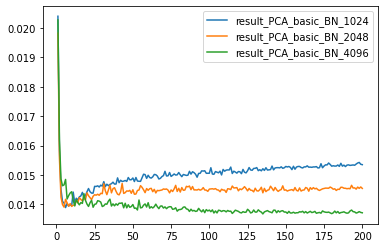

In [22]:
from matplotlib import pyplot as plt

#FN_arr = ['result_basic_1024', 'result_basic_2048', 'result_basic_4096']
#FN_arr = ['result_dr5_1024', 'result_dr5_2048', 'result_dr5_4096']
#FN_arr = ['result_BN_1024', 'result_BN_2048', 'result_BN_4096']
#FN_arr = ['result_basic_4096', 'result_dr5_4096', 'result_BN_4096']
#FN_arr = ['result_basic_1024']
#FN_arr = ['result_basic_2048']
#FN_arr = ['result_basic_4096']
#FN_arr = ['result_dr5_1024']
#FN_arr = ['result_dr5_2048']
#FN_arr = ['result_dr5_4096']
#FN_arr = ['result_BN_1024']
#FN_arr = ['result_BN_2048']
#FN_arr = ['result_BN_4096']
FN_arr = ['result_basic_1024', 'result_basic_2048', 'result_basic_4096']
##FN_arr = ['result_basic_dr3_1024', 'result_basic_dr3_2048', 'result_basic_dr3_4096']
FN_arr = ['result_basic_dr5_1024', 'result_basic_dr5_2048', 'result_basic_dr5_4096']
FN_arr = ['result_basic_BN_1024', 'result_basic_BN_2048', 'result_basic_BN_4096']
FN_arr = ['result_AE_basic_1024', 'result_AE_basic_2048', 'result_AE_basic_4096']
FN_arr = ['result_AE_basic_dr3_1024', 'result_AE_basic_dr3_2048', 'result_AE_basic_dr3_4096']
FN_arr = ['result_AE_basic_dr5_1024', 'result_AE_basic_dr5_2048', 'result_AE_basic_dr5_4096']
FN_arr = ['result_AE_basic_BN_1024', 'result_AE_basic_BN_2048', 'result_AE_basic_BN_4096']
#FN_arr = ['result_PCA_basic_1024', 'result_PCA_basic_2048', 'result_PCA_basic_4096']
#FN_arr = ['result_PCA_basic_dr3_1024', 'result_PCA_basic_dr3_2048', 'result_PCA_basic_dr3_4096']
#FN_arr = ['result_PCA_basic_dr5_1024', 'result_PCA_basic_dr5_2048', 'result_PCA_basic_dr5_4096']
FN_arr = ['result_PCA_basic_BN_1024', 'result_PCA_basic_BN_2048', 'result_PCA_basic_BN_4096']

for i in FN_arr:
    fd = open('./result/' + i, 'r')
    msg = fd.read().split('\n')
    train_loss = msg[0].split('[')[1].split(']')[0].split(',')
    train_loss = list(map(float, train_loss))

    val_loss = msg[0].split('[')[2].split(']')[0].split(',')
    val_loss = list(map(float, val_loss))

    plt.plot(range(1,len(train_loss)+1), val_loss)

plt.legend(FN_arr)
plt.savefig('figD.png', dpi=300)

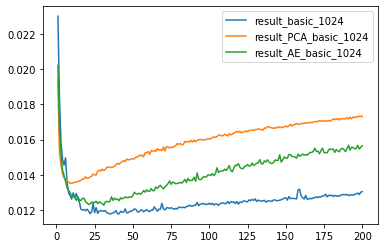

In [40]:
from matplotlib import pyplot as plt

FN_arr = ['result_basic_1024', 'result_PCA_basic_1024', 'result_AE_basic_1024']
#FN_arr = ['result_basic_2048', 'result_PCA_basic_2048', 'result_AE_basic_2048']
#FN_arr = ['result_basic_4096', 'result_PCA_basic_4096', 'result_AE_basic_4096']
#FN_arr = ['result_basic_dr3_1024', 'result_PCA_basic_dr3_1024', 'result_AE_basic_dr3_1024']
#FN_arr = ['result_basic_dr3_2048', 'result_PCA_basic_dr3_2048', 'result_AE_basic_dr3_2048']
#FN_arr = ['result_basic_dr3_4096', 'result_PCA_basic_dr3_4096', 'result_AE_basic_dr3_4096']
#FN_arr = ['result_basic_dr5_1024', 'result_PCA_basic_dr5_1024', 'result_AE_basic_dr5_1024']
#FN_arr = ['result_basic_dr5_2048', 'result_PCA_basic_dr5_2048', 'result_AE_basic_dr5_2048']
#FN_arr = ['result_basic_dr5_4096', 'result_PCA_basic_dr5_4096', 'result_AE_basic_dr5_4096']
#FN_arr = ['result_basic_BN_1024', 'result_PCA_basic_BN_1024', 'result_AE_basic_BN_1024']
#FN_arr = ['result_basic_BN_2048', 'result_PCA_basic_BN_2048', 'result_AE_basic_BN_2048']
#FN_arr = ['result_basic_BN_4096', 'result_PCA_basic_BN_4096', 'result_AE_basic_BN_4096']

for i in FN_arr:
    fd = open('./result/' + i, 'r')
    msg = fd.read().split('\n')
    train_loss = msg[0].split('[')[1].split(']')[0].split(',')
    train_loss = list(map(float, train_loss))

    val_loss = msg[0].split('[')[2].split(']')[0].split(',')
    val_loss = list(map(float, val_loss))

    plt.plot(range(1,len(train_loss)+1), val_loss)

plt.legend(FN_arr)
plt.savefig('figD.png', dpi=300)

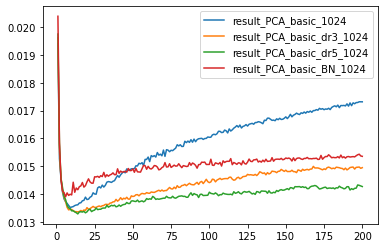

In [55]:
from matplotlib import pyplot as plt

FN_arr = ['result_basic_1024', 'result_basic_dr3_1024', 'result_basic_dr5_1024', 'result_basic_BN_1024']
FN_arr = ['result_basic_2048', 'result_basic_dr3_2048', 'result_basic_dr5_2048', 'result_basic_BN_2048']
FN_arr = ['result_basic_4096', 'result_basic_dr3_4096', 'result_basic_dr5_4096', 'result_basic_BN_4096']

FN_arr = ['result_PCA_basic_1024', 'result_PCA_basic_dr3_1024', 'result_PCA_basic_dr5_1024', 'result_PCA_basic_BN_1024']
#FN_arr = ['result_PCA_basic_2048', 'result_PCA_basic_dr3_2048', 'result_PCA_basic_dr5_2048', 'result_PCA_basic_BN_2048']
#FN_arr = ['result_PCA_basic_4096', 'result_PCA_basic_dr3_4096', 'result_PCA_basic_dr5_4096', 'result_PCA_basic_BN_4096']

#FN_arr = ['result_AE_basic_1024', 'result_AE_basic_dr3_1024', 'result_AE_basic_dr5_1024', 'result_AE_basic_BN_1024']
#FN_arr = ['result_AE_basic_2048', 'result_AE_basic_dr3_2048', 'result_AE_basic_dr5_2048', 'result_AE_basic_BN_2048']
#FN_arr = ['result_AE_basic_4096', 'result_AE_basic_dr3_4096', 'result_AE_basic_dr5_4096', 'result_AE_basic_BN_4096']

for i in FN_arr:
    fd = open('./result/' + i, 'r')
    msg = fd.read().split('\n')
    train_loss = msg[0].split('[')[1].split(']')[0].split(',')
    train_loss = list(map(float, train_loss))

    val_loss = msg[0].split('[')[2].split(']')[0].split(',')
    val_loss = list(map(float, val_loss))

    plt.plot(range(1,len(train_loss)+1), val_loss)

plt.legend(FN_arr)
plt.savefig('figD.png', dpi=300)

In [56]:
from PIL import Image

img = Image.open('figD.png')

print (img.size)

area = (60, 140, 1620, 1120)
img_crop = img.crop(area)
img_crop.save('figD.png')

(1800, 1200)


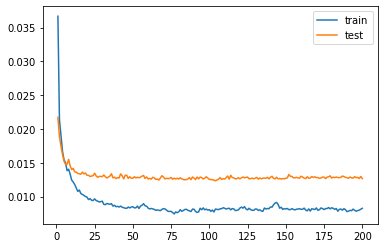

In [65]:
from matplotlib import pyplot as plt

#FN_arr = ['result_basic_1024', 'result_basic_2048', 'result_basic_4096']
#FN_arr = ['result_dr5_1024', 'result_dr5_2048', 'result_dr5_4096']
#FN_arr = ['result_BN_1024', 'result_BN_2048', 'result_BN_4096']
#FN_arr = ['result_basic_4096', 'result_dr5_4096', 'result_BN_4096']
#FN_arr = ['result_basic_1024']
#FN_arr = ['result_basic_2048']
#FN_arr = ['result_basic_4096']
FN_arr = ['result_basic_dr5_1024']
#FN_arr = ['result_dr5_2048']
#FN_arr = ['result_dr5_4096']
#FN_arr = ['result_BN_1024']
#FN_arr = ['result_BN_2048']
#FN_arr = ['result_BN_4096']

for i in FN_arr:
    fd = open('./result/' + i, 'r')
    msg = fd.read().split('\n')
    train_loss = msg[0].split('[')[1].split(']')[0].split(',')
    train_loss = list(map(float, train_loss))

    val_loss = msg[0].split('[')[2].split(']')[0].split(',')
    val_loss = list(map(float, val_loss))

    plt.plot(range(1,len(train_loss)+1), train_loss)
    plt.plot(range(1,len(train_loss)+1), val_loss)

plt.legend(['train', 'test'])
#plt.savefig('figD.png', dpi=300)